### Import Libraries

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import os
from time import time
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
import re
import fnmatch

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### Extract the data into dataframe

In [2]:
signals = ['glucose','Breathing','ECG','Accel','Summary']
dataset_path='F:/btp_working_directory'

In [3]:
def Patient_Data(Patient_number):   
    
    import warnings
    warnings.filterwarnings("ignore")

    def Summary_readings():    
 
        summary = pd.DataFrame()

        for i in [1,2,3,4,5,6,7,8,9]:
            files = glob.glob('F:/btp_working_directory/D1NAMO/**/*.csv',recursive=True)
            x = os.path.join('*dia**/'+'00'+str(i)+'/sensor_data/'+'*'+signals[-1]+'.csv')
            path= [file for file in files if fnmatch.fnmatch(file,x)]

            #read all glucose files for all diabetic subjects
            summ_patient = pd.concat([pd.read_csv(file) for file in path],axis=0)
            summ_patient['patient']=i
            summary = summary.append(summ_patient)

        ## convert the time column to be the index

        summary['Time'] = pd.to_datetime(summary['Time'],format='%d/%m/%Y %H:%M:%S.%f')
        summary['Time'] = summary['Time'].astype('datetime64[s]')
        summary = summary.set_index(summary['Time'])
        summary.drop(columns =['Time'],inplace=True)

        return summary
    
    summary = Summary_readings()    
    summary_patient = summary[summary.patient==Patient_number]
    
    files = glob.glob('F:/btp_working_directory/D1NAMO/**/*.csv',recursive=True)
    x = os.path.join('*dia**/'+'**/'+'glucose'+'.csv')

    #read all glucose files for all diabetic subjects
    glucoses = [pd.read_csv(file).drop(['type','comments'],axis=1) for file in files if fnmatch.fnmatch(file,x)]


    #Identify patient by adding a column with subject number staring from 1 to 9
    for i,glu in enumerate(glucoses):
        glu['patient'] = np.ones(glu.shape[0])*(i+1) 

    # glucoses: adding differntiation column
    for glu in glucoses:
        glu['glucose_diff'] = glu.glucose.diff()

    glucose = pd.concat(glucoses,axis = 0 )
    glucose['time'] = glucose.pipe(lambda x : pd.to_datetime(x['date']+' '+x['time']))    
    glucose.drop(columns=['date'],inplace=True)
    glucose['bin_number']= glucose.index
    glucose.index = glucose['time']
    glucose.drop(columns=['time'],inplace=True)
    
    try:
        glucose_patient = glucose.iloc[glucose.reset_index().groupby('patient').groups[Patient_number]].resample('1s').fillna(method='ffill')
    
    except:
        x=glucose[glucose['patient']==Patient_number]
        x1=x[x.index.value_counts()>1].reset_index().drop_duplicates(subset='time', keep='first')
        x1.set_index('time',inplace=True)
        x2=x[x.index.value_counts()<2]
        x3=pd.concat([x2,x1],axis=0,sort=True)
        x3.sort_index(inplace=True)
        glucose_patient = x3.iloc[x3.reset_index().groupby('patient').groups[Patient_number]].resample('1s').fillna(method='ffill')

    the_join= glucose_patient.join(summary_patient,lsuffix='g',rsuffix='s',how='inner')
    
    return the_join


In [4]:
for i in [1,2,4,5,6,7,8,9]:
    if(i == 1):
        x = Patient_Data(i).reset_index(drop=True)
    else:    
        x = pd.concat([x,Patient_Data(i).reset_index(drop=True)],axis=0,ignore_index=True)

In [5]:
xx = x.drop(["bin_number", "patientg", "BR","SkinTemp", "Posture", "Activity", "PeakAccel", "BatteryVolts","BatteryLevel", "BRAmplitude", "BRNoise", "BRConfidence","SystemConfidence","GSR", "ROGState", "ROGTime", "VerticalMin", "VerticalPeak","LateralMin", "LateralPeak", "SagittalMin", "SagittalPeak","DeviceTemp", "StatusInfo", "LinkQuality", "RSSI", "TxPower","CoreTemp", "AuxADC1", "AuxADC2", "AuxADC3", "patients"],axis=1)
pp_data = xx[xx['HR']>45]
pp_data = pp_data[pp_data['glucose_diff'].notnull()]
pp_data = pp_data.drop("glucose_diff",axis=1)
p=pp_data

In [6]:
glucose = pp_data['glucose']
glucose_labels = glucose.copy()
pp_data = pp_data.drop('glucose',axis=1)


### Tesrt-Train Split

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pp_data, glucose_labels, test_size=0.33, random_state=42)

### Linear Regression

In [11]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [12]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X_train,y_train)
reg.score(X_test,y_test)


0.015342627216033522

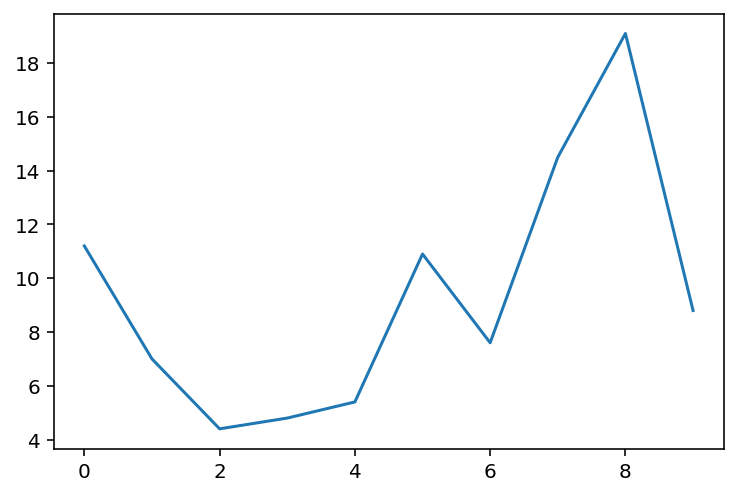

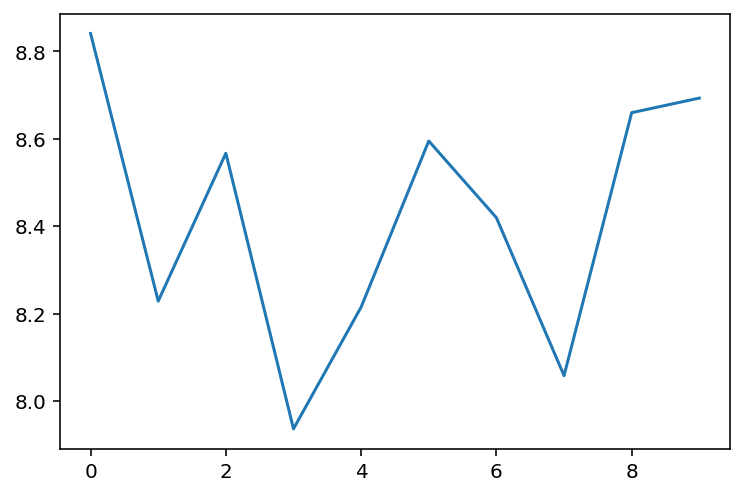

In [15]:
y_pred = reg.predict(X_test)
plt.plot(np.array(y_test)[3800:3810])
plt.show()
plt.plot(y_pred[3800:3810])
plt.show()

In [16]:
print(explained_variance_score(np.array(y_test),y_pred))
print(r2_score(np.array(y_test),y_pred))
print(mean_squared_error(np.array(y_test),y_pred))

0.015361504071933929
0.015342627216033522
16.404307385759683


### Ridge Regression

In [17]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha=.5)
reg.fit(X_train,y_train)
reg.score(X_test,y_test)


0.014694188938380592

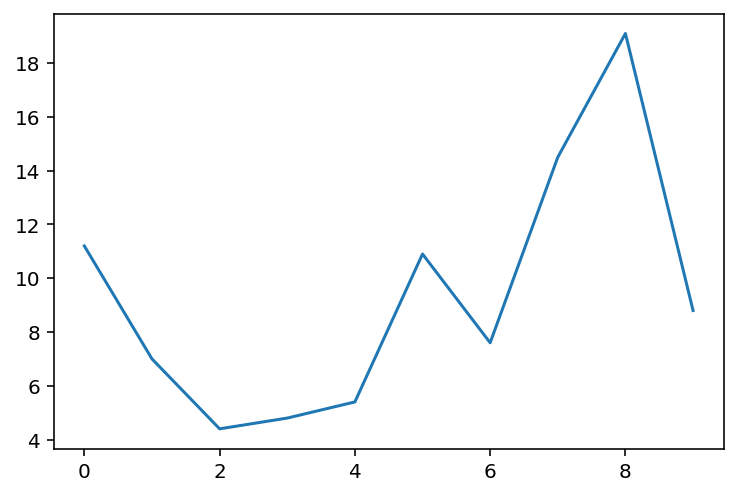

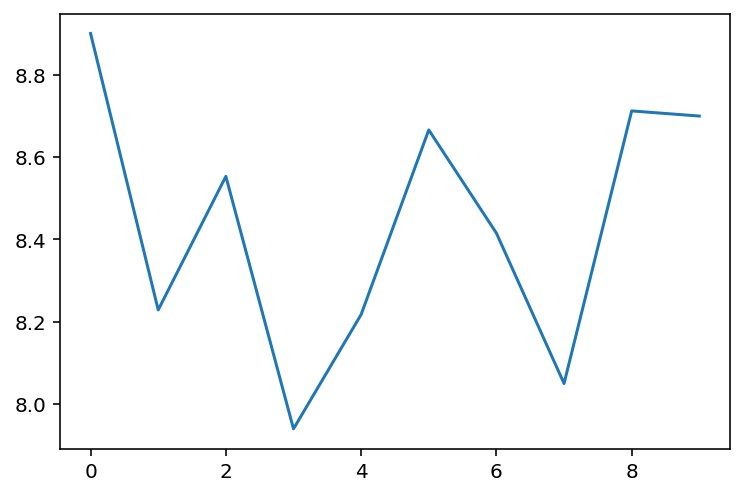

In [19]:
y_pred = reg.predict(X_test)
plt.plot(np.array(y_test)[3800:3810])
plt.show()
plt.plot(y_pred[3800:3810])
plt.show()

In [20]:
print(explained_variance_score(np.array(y_test),y_pred))
print(r2_score(np.array(y_test),y_pred))
print(mean_squared_error(np.array(y_test),y_pred))

0.014712803846466449
0.014694188938380592
16.415110311854917


### Lasso

In [21]:
from sklearn import linear_model
reg = linear_model.Lasso(alpha=.5)
reg.fit(X_train,y_train)
reg.score(X_test,y_test)

0.013706929282244706

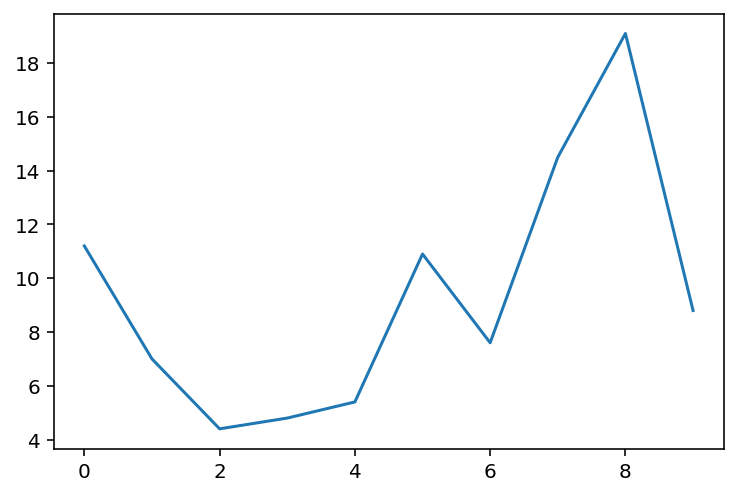

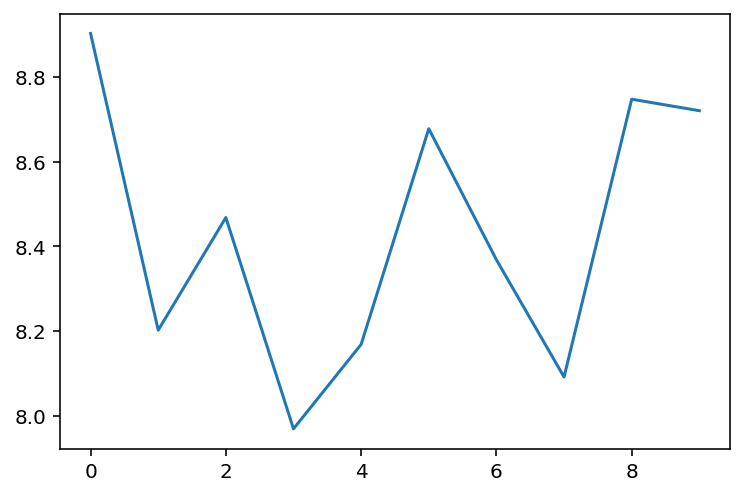

In [22]:
y_pred = reg.predict(X_test)
plt.plot(np.array(y_test)[3800:3810])
plt.show()
plt.plot(y_pred[3800:3810])
plt.show()

In [23]:
print(explained_variance_score(np.array(y_test),y_pred))
print(r2_score(np.array(y_test),y_pred))
print(mean_squared_error(np.array(y_test),y_pred))

0.013725431537168098
0.013706929282244706
16.431557973058144


### ElasticNet

In [25]:
from sklearn import linear_model
reg = linear_model.ElasticNet(alpha=.5)
reg.fit(X_train,y_train)
reg.score(X_test,y_test)

0.013751172368715814

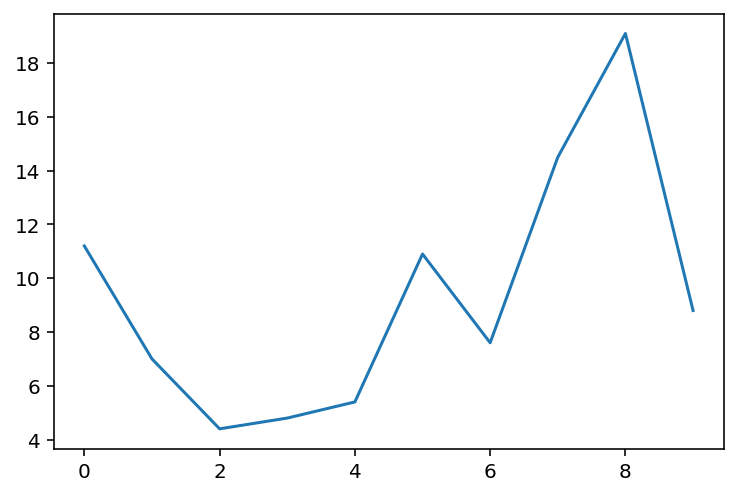

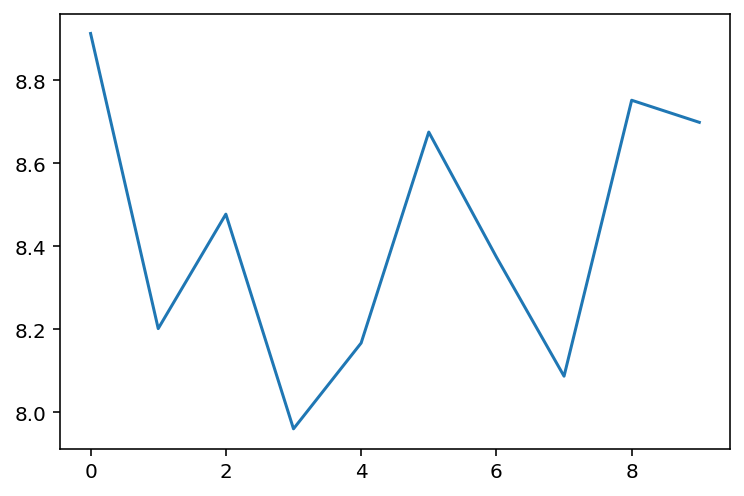

In [26]:
y_pred = reg.predict(X_test)
plt.plot(np.array(y_test)[3800:3810])
plt.show()
plt.plot(y_pred[3800:3810])
plt.show()

In [27]:
print(explained_variance_score(np.array(y_test),y_pred))
print(r2_score(np.array(y_test),y_pred))
print(mean_squared_error(np.array(y_test),y_pred))

0.013769686014572291
0.013751172368715814
16.43082088703185


### Passive Agressive Regressor

In [28]:
from sklearn.linear_model import PassiveAggressiveRegressor
regr = PassiveAggressiveRegressor(max_iter=100, random_state=0, tol=1e-3)
regr.fit(X_train, y_train)
regr.score(X_test,y_test)

-130.29724655458884

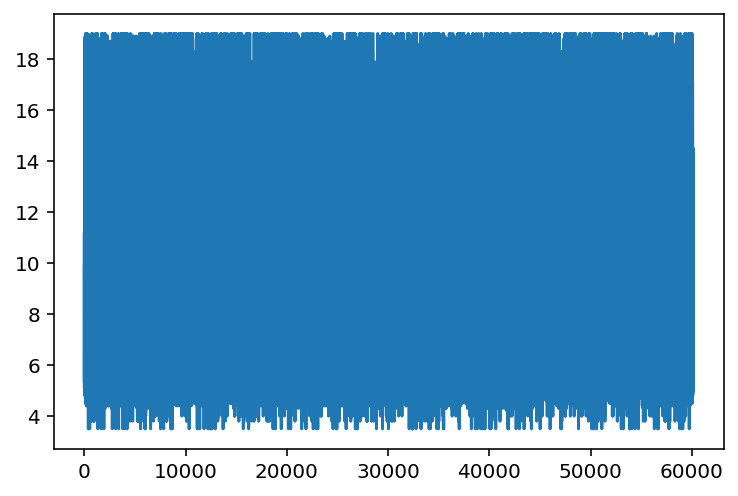

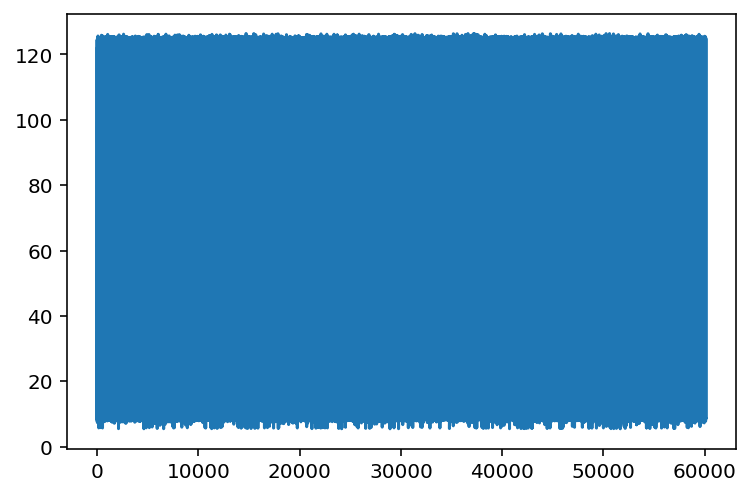

In [65]:
y_pred = regr.predict(X_test)
plt.plot(np.array(y_test)[3800:3810])
plt.show()
plt.plot(y_pred[3800:3810])
plt.show()

In [82]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(max_iter=100, learning_rate = "adaptive").fit(X_train, y_train)

In [83]:
regr.score(X_test,y_test)

-0.07066776577366451

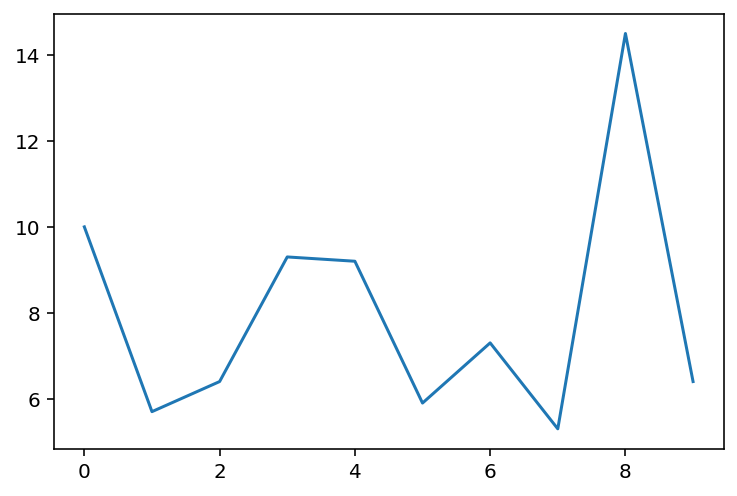

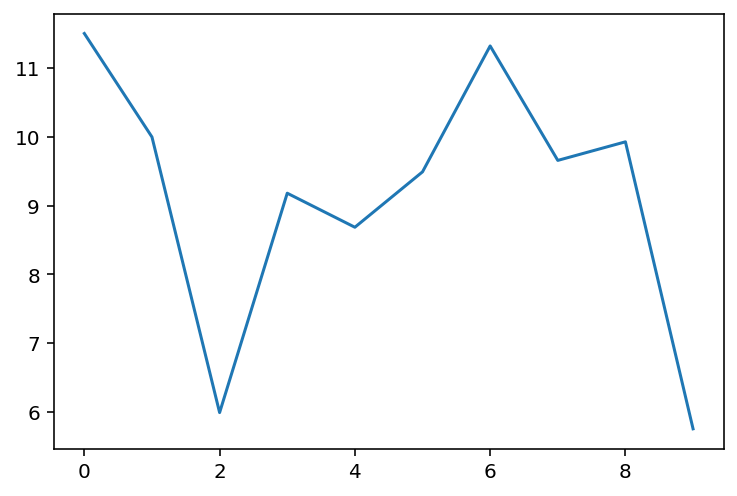

In [85]:
y_pred = regr.predict(X_test)
plt.plot(np.array(y_test)[3800:3810])
plt.show()
plt.plot(y_pred[3800:3810])
plt.show()

-0.03882337923630197
-0.07066776577366451
11.827144164397062
